# Dependencies

In [1]:
import pyspark
from delta import configure_spark_with_delta_pip
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, dayofweek, month, date_format
from pyspark.sql.types import StructType, StructField, DateType, StringType, IntegerType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Dict, Tuple


from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count, mean, stddev
from pyspark.ml.feature import Imputer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Spark session fn

In [2]:
def create_spark_session(app_name: str = "AirlineDelayPrediction", 
                        memory: str = "32g",
                        cores: str = "8") -> SparkSession:
    """Create and configure Spark session with optimal settings"""
    spark = SparkSession.builder \
        .appName(app_name) \
        .config("spark.master", f"local[{cores}]") \
        .config("spark.executor.memory", memory) \
        .config("spark.driver.memory", memory) \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.driver.maxResultSize", "10g") \
        .config("spark.memory.fraction", "0.8") \
        .config("spark.memory.storageFraction", "0.3") \
        .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:G1HeapRegionSize=32M")\
        .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC -XX:G1HeapRegionSize=32M") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.default.parallelism", 16)\
        .getOrCreate()
    
    print(f"Spark version: {spark.version}")
    return spark

# Data Ingestion fn

In [3]:
def define_schema() -> StructType:
    """Define schema for airline data"""
    return StructType([
        StructField("FL_DATE", DateType(), True),
        StructField("OP_CARRIER", StringType(), True),
        StructField("OP_CARRIER_FL_NUM", IntegerType(), True),
        StructField("ORIGIN", StringType(), True),
        StructField("DEST", StringType(), True),
        StructField("CRS_DEP_TIME", IntegerType(), True),
        StructField("DEP_TIME", DoubleType(), True),
        StructField("DEP_DELAY", DoubleType(), True),
        StructField("TAXI_OUT", DoubleType(), True),
        StructField("WHEELS_OFF", DoubleType(), True),
        StructField("WHEELS_ON", DoubleType(), True),
        StructField("TAXI_IN", DoubleType(), True),
        StructField("CRS_ARR_TIME", IntegerType(), True),
        StructField("ARR_TIME", DoubleType(), True),
        StructField("ARR_DELAY", DoubleType(), True),
        StructField("CANCELLED", DoubleType(), True),
        StructField("CANCELLATION_CODE", StringType(), True),
        StructField("DIVERTED", DoubleType(), True),
        StructField("CRS_ELAPSED_TIME", DoubleType(), True),
        StructField("ACTUAL_ELAPSED_TIME", DoubleType(), True),
        StructField("AIR_TIME", DoubleType(), True),
        StructField("DISTANCE", DoubleType(), True),
        StructField("CARRIER_DELAY", DoubleType(), True),
        StructField("WEATHER_DELAY", DoubleType(), True),
        StructField("NAS_DELAY", DoubleType(), True),
        StructField("SECURITY_DELAY", DoubleType(), True),
        StructField("LATE_AIRCRAFT_DELAY", DoubleType(), True)
    ])

def load_data(spark: SparkSession, file_path: str, schema: StructType = None) -> 'DataFrame':
    """Load CSV data with optional schema"""
    if schema:
        return spark.read.option("header", "true")\
            .option("mode", "PERMISSIVE")\
            .schema(schema).csv(file_path)
    else:
        return spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

def load_cleaned_data(spark: SparkSession, year: str = "2009") -> 'DataFrame':
    """Load pre-cleaned parquet data for a given year"""
    parquet_path = f"input/{year}_cleaned.parquet"
    
    # Check if parquet exists
    try:
        df = spark.read.parquet(parquet_path)
        print(f"Loaded {year} data: {df.count()} rows, {len(df.columns)} columns")
        return df
    except:
        print(f"Error: Parquet file not found at {parquet_path}")
        print("Please run the data cleaning pipeline first.")
        return None

def write_partitioned_parquet(df: 'DataFrame', output_path: str, partition_cols: List[str] = ["Month", "DayOfWeek"]):
    """Write data as partitioned Parquet format"""
    df.write.mode("overwrite").partitionBy(partition_cols).parquet(output_path)
    print(f"Data written to {output_path} partitioned by {partition_cols}")

def read_parquet(spark: SparkSession, parquet_path: str) -> 'DataFrame':
    """Read partitioned Parquet data"""
    df = spark.read.parquet(parquet_path)
    print(f"Read parquet from {parquet_path}: {df.count()} rows, {len(df.columns)} columns")
    return df

# Data cleaning fn

In [4]:
def rename_columns(df: 'DataFrame') -> 'DataFrame':
    """Rename columns for consistency"""
    column_mapping = {
        "OP_CARRIER": "UniqueCarrier",
        "OP_CARRIER_FL_NUM": "FlightNum",
        "CRS_DEP_TIME": "CRSDepTime",
        "CRS_ARR_TIME": "CRSArrTime",
        "CRS_ELAPSED_TIME": "CRSElapsedTime",
        "ACTUAL_ELAPSED_TIME": "ActualElapsedTime",
        "CANCELLATION_CODE": "CancellationCode",
        "CARRIER_DELAY": "CarrierDelay",
        "WEATHER_DELAY": "WeatherDelay",
        "NAS_DELAY": "NASDelay",
        "SECURITY_DELAY": "SecurityDelay",
        "LATE_AIRCRAFT_DELAY": "LateAircraftDelay"
    }
    
    # Apply renaming
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.withColumnRenamed(old_name, new_name)
    
    return df

def remove_unused_columns(df: 'DataFrame') -> 'DataFrame':
    df = df.drop("Unnamed: 27")
    
    return df

def remove_no_useful_columns(df: 'DataFrame') -> 'DataFrame':
    exclude_features = [
    "CancellationCode",  #leak
    "DEP_TIME",
    "ARR_TIME",
    "WHEELS_OFF",
    "WHEELS_ON",
    "AIR_TIME",
    "ActualElapsedTime",
    #"TAXI_OUT",
    #"TAXI_IN",
    ]
    df = df.drop(*exclude_features)

    return df

def create_temporal_features(df: 'DataFrame') -> 'DataFrame':
    """Create DayOfWeek and Month features from FL_DATE"""
    return df.withColumn("DayOfWeek", dayofweek(col("FL_DATE"))) \
             .withColumn("Month", month(col("FL_DATE")))


def handle_missing_values(df: 'DataFrame', numeric_cols: List[str] = None, strategy: str = "zero") -> 'DataFrame':
    """Handle missing values in numeric columns"""
    if numeric_cols is None:
        numeric_cols = ["DEP_DELAY", "ARR_DELAY", "TAXI_OUT", "TAXI_IN", 
                       "CarrierDelay", "WeatherDelay", "NASDelay", 
                       "SecurityDelay", "LateAircraftDelay"]
    
    for col_name in numeric_cols:
        if col_name in df.columns:
            if strategy == "zero":
                df = df.fillna({col_name: 0.0})
            elif strategy == "mean":
                mean_val = df.select(col_name).na.drop().agg({col_name: "mean"}).collect()[0][0]
                df = df.fillna({col_name: mean_val})
    
    return df


def filter_diverted_flights(df: 'DataFrame') -> 'DataFrame':
    """Filter out diverted flights"""
    return df.filter(col("DIVERTED") != 1)


def prepare_label(df: 'DataFrame', label_col: str = "CANCELLED") -> 'DataFrame':
    """Convert label to integer type"""
    return df.withColumn("label", col(label_col).cast("integer"))

# EDA fn

In [5]:
def analyze_top_carriers(df: 'DataFrame', top_n: int = 10) -> 'DataFrame':
    """Analyze top carriers by flight count"""
    top_carriers = df.groupBy("UniqueCarrier") \
                    .agg(count("*").alias("FlightCount")) \
                    .orderBy(col("FlightCount").desc()) \
                    .limit(top_n)
    
    return top_carriers


def analyze_cancellation_reasons(df: 'DataFrame') -> 'DataFrame':
    """Analyze cancellation reasons"""
    cancellation_stats = df.filter(col("CANCELLED") == 1) \
                          .groupBy("CancellationCode") \
                          .agg(count("*").alias("Count")) \
                          .orderBy(col("Count").desc())
    
    return cancellation_stats


def calculate_class_distribution(df: 'DataFrame', label_col: str = "label") -> Dict:
    """Calculate class distribution and imbalance ratio"""
    class_counts = df.groupBy(label_col).count().collect()
    
    distribution = {row[label_col]: row["count"] for row in class_counts}
    total = sum(distribution.values())
    
    # Calculate percentages
    percentages = {k: (v/total)*100 for k, v in distribution.items()}
    
    # Calculate imbalance ratio
    if 0 in distribution and 1 in distribution:
        imbalance_ratio = distribution[0] / distribution[1]
    else:
        imbalance_ratio = None
    
    return {
        "counts": distribution,
        "percentages": percentages,
        "imbalance_ratio": imbalance_ratio
    }


def visualize_cancellation_reasons(df: 'DataFrame', save_path: str = None):
    """Visualize cancellation reasons"""
    cancellation_stats = analyze_cancellation_reasons(df).toPandas()
    
    # Map cancellation codes to full names
    code_mapping = {
        'A': 'Carrier',
        'B': 'Weather',
        'C': 'National Air System',
        'D': 'Security'
    }
    
    cancellation_stats['Reason'] = cancellation_stats['CancellationCode'].map(code_mapping)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=cancellation_stats, x='Reason', y='Count', palette='viridis')
    plt.title('Flight Cancellation Reasons')
    plt.ylabel('Number of Cancellations')
    plt.xlabel('Cancellation Reason')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## Missing values

In [6]:
def analyze_missing_values(df: 'DataFrame') -> pd.DataFrame:
    """Comprehensive missing value analysis"""
    total_rows = df.count()
    
    missing_stats = []
    for column in df.columns:
        # Count nulls
        null_count = df.filter(col(column).isNull()).count()
        
        # For numeric columns, also check for NaN
        if column in ['DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 'AIR_TIME', 
                     'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']:
            nan_count = df.filter(isnan(col(column))).count()
            total_missing = null_count + nan_count
        else:
            total_missing = null_count
        
        missing_percent = (total_missing / total_rows) * 100
        
        missing_stats.append({
            'column': column,
            'missing_count': total_missing,
            'missing_percent': missing_percent,
            'data_type': str(df.schema[column].dataType)
        })
    
    missing_df = pd.DataFrame(missing_stats)
    missing_df = missing_df.sort_values('missing_percent', ascending=False)
    
    return missing_df

def visualize_missing_patterns(df: 'DataFrame', missing_df: pd.DataFrame):
    """Visualize missing data patterns"""
    
    # Filter columns with missing values
    missing_cols = missing_df[missing_df['missing_percent'] > 0]['column'].tolist()
    
    if not missing_cols:
        print("No missing values found in the dataset!")
        return
    
    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Bar chart of missing percentages
    ax1 = axes[0]
    missing_data = missing_df[missing_df['missing_percent'] > 0].head(15)
    
    bars = ax1.bar(range(len(missing_data)), missing_data['missing_percent'], 
                   color=sns.color_palette("YlOrRd", len(missing_data)))
    ax1.set_xlabel('Columns')
    ax1.set_ylabel('Missing Percentage (%)')
    ax1.set_title('Missing Value Percentages by Column', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(missing_data)))
    ax1.set_xticklabels(missing_data['column'], rotation=45, ha='right')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Heatmap of missing patterns correlation
    ax2 = axes[1]
    
    # Create binary missing indicator for correlation
    missing_indicators = []
    for col_name in missing_cols[:10]:  # Changed variable name from 'col' to 'col_name'
        missing_indicators.append(
            df.select(when(col(col_name).isNull(), 1).otherwise(0).alias(f"{col_name}_missing"))
        )
    
    if missing_indicators:
        # Combine and calculate correlation
        missing_combined = missing_indicators[0]
        for indicator in missing_indicators[1:]:
            missing_combined = missing_combined.join(indicator)
        
        # Convert to pandas and calculate correlation
        missing_corr = missing_combined.toPandas().corr()
        
        # Plot heatmap
        sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0, 
                   square=True, ax=ax2, cbar_kws={"shrink": .8})
        ax2.set_title('Missing Value Patterns Correlation', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return missing_cols

def analyze_missing_patterns_by_class(df: 'DataFrame', target_col: str = 'CANCELLED'):
    """Analyze missing patterns by target class"""
    
    # Select columns with missing values
    missing_cols = []
    for column in df.columns:
        if df.filter(F.col(column).isNull()).count() > 0:
            missing_cols.append(column)
    
    if not missing_cols:
        print("No missing values found!")
        return
    
    # Analyze missing patterns by cancellation status
    missing_by_class = df.groupBy(target_col).agg(
        *[F.sum(when(F.col(c).isNull(), 1).otherwise(0)).alias(f"{c}_missing") 
          for c in missing_cols],
        count("*").alias("total_count")
    ).toPandas()
    
    # Convert to percentages
    for column in missing_cols:
        missing_by_class[f"{column}_missing_pct"] = (missing_by_class[f"{column}_missing"] / 
                                                 missing_by_class['total_count'] * 100)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    
    width = 0.35
    x = range(len(missing_cols))
    
    # Plot for cancelled flights
    cancelled_data = missing_by_class[missing_by_class[target_col] == 1]
    not_cancelled_data = missing_by_class[missing_by_class[target_col] == 0]
    
    if len(cancelled_data) > 0 and len(not_cancelled_data) > 0:
        cancelled_pcts = [cancelled_data.iloc[0][f"{column}_missing_pct"] for column in missing_cols]
        not_cancelled_pcts = [not_cancelled_data.iloc[0][f"{column}_missing_pct"] for column in missing_cols]
        
        ax.bar([i - width/2 for i in x], cancelled_pcts, width, 
               label='Cancelled', color='red', alpha=0.7)
        ax.bar([i + width/2 for i in x], not_cancelled_pcts, width, 
               label='Not Cancelled', color='green', alpha=0.7)
        
        ax.set_xlabel('Columns')
        ax.set_ylabel('Missing Percentage (%)')
        ax.set_title('Missing Values by Cancellation Status', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([column[:15] for column in missing_cols], rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return missing_by_class

# Feature Engineering fn

In [37]:
def select_features(df: 'DataFrame') -> List[str]:
    """Select features for modeling"""
    categorical_features = ["ORIGIN", "DEST", "DayOfWeek", "Month"]
    numeric_features = ["DISTANCE", "CRSDepTime", "CRSArrTime", "CRSElapsedTime"]
    
    # Optional: add delay features if not predicting cancellation in advance
    # numeric_features.extend(["DEP_DELAY", "ARR_DELAY"])
    
    return categorical_features, numeric_features


def create_feature_pipeline(categorical_features: List[str], numeric_features: List[str]) -> Pipeline:
    """Create feature engineering pipeline"""
    stages = []
    
    # String indexing for categorical features
    for cat_col in categorical_features:
        indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_indexed",handleInvalid="keep")
        encoder = OneHotEncoder(inputCol=f"{cat_col}_indexed", outputCol=f"{cat_col}_encoded")
        stages.extend([indexer, encoder])
    
    # Assemble all features
    encoded_features = [f"{col}_encoded" for col in categorical_features]
    assembler_inputs = encoded_features + numeric_features
    
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features", handleInvalid='skip')
    stages.append(assembler)
    
    return Pipeline(stages=stages)

# Class Balancing

In [8]:
def balance_classes_oversampling(df: 'DataFrame', label_col: str = "label", ratio: float = 0.5) -> 'DataFrame':
    """Balance classes using oversampling of minority class"""
    # Get counts
    minority_count = df.filter(col(label_col) == 1).count()
    majority_count = df.filter(col(label_col) == 0).count()
    
    # Calculate how many minority samples we need
    target_minority_count = int(majority_count * ratio)
    oversample_factor = target_minority_count / minority_count
    
    # Oversample minority class
    minority_df = df.filter(col(label_col) == 1)
    majority_df = df.filter(col(label_col) == 0)
    
    # Sample with replacement
    oversampled_minority = minority_df.sample(
        fraction=oversample_factor, 
        seed=42, 
        withReplacement=True
    )

    # Combine
    balanced_df = majority_df.union(oversampled_minority)
    
    print(f"Original ratio: {majority_count/minority_count:.2f}:1")
    print(f"New ratio: {majority_count/target_minority_count:.2f}:1")
    
    return balanced_df


In [9]:
# Modeling fn

In [10]:
def create_models() -> Dict:
    """Create dictionary of ML models"""
    return {
        "LogisticRegression": LogisticRegression(maxIter=100, elasticNetParam=0.8),
        "DecisionTree": DecisionTreeClassifier(maxDepth=10),
        "RandomForest": RandomForestClassifier(numTrees=50, maxDepth=10),
        "GBT": GBTClassifier(maxIter=50, maxDepth=5)
    }


def create_param_grids() -> Dict:
    """Create parameter grids for each model"""
    return {
        "LogisticRegression": ParamGridBuilder()
            .addGrid(LogisticRegression.regParam, [0.01, 0.1, 1.0])
            .build(),
        
        "DecisionTree": ParamGridBuilder()
            .addGrid(DecisionTreeClassifier.maxDepth, [5, 10, 15])
            .addGrid(DecisionTreeClassifier.minInstancesPerNode, [1, 5, 10])
            .build(),
        
        "RandomForest": ParamGridBuilder()
            .addGrid(RandomForestClassifier.numTrees, [20, 50, 100])
            .addGrid(RandomForestClassifier.maxDepth, [5, 10, 15])
            .build(),
        
        "GBT": ParamGridBuilder()
            .addGrid(GBTClassifier.maxIter, [20, 50])
            .addGrid(GBTClassifier.maxDepth, [3, 5, 7])
            .build()
    }


def train_model_with_cv(model, param_grid, train_data, evaluator, num_folds=3):
    """Train model with cross-validation"""
    crossval = CrossValidator(estimator=model,
                             estimatorParamMaps=param_grid,
                             evaluator=evaluator,
                             numFolds=num_folds)
    
    cv_model = crossval.fit(train_data)
    return cv_model


def evaluate_model(model, test_data, label_col="label"):
    """Evaluate model using multiple metrics"""
    predictions = model.transform(test_data)
    
    # Binary classification metrics
    auc_evaluator = BinaryClassificationEvaluator(labelCol=label_col, 
                                                 rawPredictionCol="rawPrediction",
                                                 metricName="areaUnderROC")
    
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=label_col,
                                                          rawPredictionCol="prediction",
                                                          metricName="accuracy")
    
    auc = auc_evaluator.evaluate(predictions)
    accuracy = accuracy_evaluator.evaluate(predictions)
    
    return {"AUC": auc, "Accuracy": accuracy}

# Imputation Strategy

In [11]:
def create_imputation_strategy(df: 'DataFrame', missing_df: pd.DataFrame) -> dict:
    """Create imputation strategy based on missing patterns"""
    
    imputation_strategy = {}
    columns_to_drop = ["CancellationCode",  #leak
    "DEP_TIME",
    "ARR_TIME",
    "WHEELS_OFF",
    "WHEELS_ON",
    "AIR_TIME",
    "ActualElapsedTime"]
    
    for _, row in missing_df.iterrows():
        column = row['column']
        missing_pct = row['missing_percent']
        data_type = row['data_type']

        if missing_pct == 0:
            continue
        
        # Strategy based on column type and missing percentage and unuseful columns
        if missing_pct > 90 or column in columns_to_drop:
            # Too many missing values - consider dropping
            imputation_strategy[column] = 'drop'
        elif column in ['CANCELLATION_CODE']:
            # Categorical with specific meaning when missing
            imputation_strategy[column] = 'keep_missing'
        elif column.endswith('_DELAY'):
            # Delay columns - missing usually means no delay
            imputation_strategy[column] = 'fill_zero'
        elif 'Double' in data_type or 'Integer' in data_type:
            # Numeric columns
            if missing_pct < 5:
                imputation_strategy[column] = 'mean'
            elif missing_pct < 20:
                imputation_strategy[column] = 'median'
            else:
                imputation_strategy[column] = 'zero'
        elif 'String' in data_type:
            # Categorical columns
            imputation_strategy[column] = 'mode'
        else:
            imputation_strategy[column] = 'keep'
    
    return imputation_strategy


def apply_imputation(df: 'DataFrame', strategy: dict) -> 'DataFrame':
    """Apply imputation strategy to DataFrame"""
    
    df_imputed = df
    
    # Separate numeric and categorical columns
    numeric_cols_mean = []
    numeric_cols_median = []
    numeric_cols_zero = []
    categorical_cols_mode = []
    
    for column, method in strategy.items():
        if method == 'mean':
            numeric_cols_mean.append(column)
        elif method == 'median':
            numeric_cols_median.append(column)
        elif method == 'zero' or method == 'fill_zero':
            numeric_cols_zero.append(column)
        elif method == 'mode':
            categorical_cols_mode.append(column)
        elif method == 'drop':
            df_imputed = df_imputed.drop(column)
    
    # Apply mean imputation
    if numeric_cols_mean:
        imputer_mean = Imputer(
            inputCols=numeric_cols_mean,
            outputCols=[f"{col}_imputed" for col in numeric_cols_mean],
            strategy="mean"
        )
        model_mean = imputer_mean.fit(df_imputed)
        df_imputed = model_mean.transform(df_imputed)
        
        # Replace original columns
        for col in numeric_cols_mean:
            df_imputed = df_imputed.drop(col).withColumnRenamed(f"{col}_imputed", col)
    
    # Apply median imputation
    if numeric_cols_median:
        imputer_median = Imputer(
            inputCols=numeric_cols_median,
            outputCols=[f"{col}_imputed" for col in numeric_cols_median],
            strategy="median"
        )
        model_median = imputer_median.fit(df_imputed)
        df_imputed = model_median.transform(df_imputed)
        
        # Replace original columns
        for col in numeric_cols_median:
            df_imputed = df_imputed.drop(col).withColumnRenamed(f"{col}_imputed", col)
    
    # Apply zero filling
    for col in numeric_cols_zero:
        df_imputed = df_imputed.fillna(0, subset=[col])
        # Also handle NaN for numeric columns
        df_imputed = df_imputed.withColumn(
            col, 
            when(isnan(col(col)), 0).otherwise(col(col))
        )
    
    # Apply mode imputation for categorical
    for col in categorical_cols_mode:
        # Calculate mode
        mode_value = df_imputed.groupBy(col).count() \
            .orderBy("count", ascending=False) \
            .first()[col]
        
        if mode_value is not None:
            df_imputed = df_imputed.fillna(mode_value, subset=[col])
    
    return df_imputed

def validate_imputation(df_original: 'DataFrame', df_imputed: 'DataFrame'):
    """Validate imputation results"""
    
    print("=== Imputation Validation ===")
    
    # Compare missing values before and after
    missing_before = analyze_missing_values(df_original)
    missing_after = analyze_missing_values(df_imputed)
    
    comparison = pd.merge(
        missing_before[['column', 'missing_percent']],
        missing_after[['column', 'missing_percent']],
        on='column',
        suffixes=('_before', '_after')
    )
    
    comparison['reduction'] = comparison['missing_percent_before'] - comparison['missing_percent_after']
    
    # Display results
    print("\nMissing Value Reduction:")
    print(comparison[comparison['reduction'] > 0].to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(comparison[comparison['reduction'] > 0]))
    width = 0.35
    
    data = comparison[comparison['reduction'] > 0]
    
    ax.bar([i - width/2 for i in x], data['missing_percent_before'], width, 
           label='Before', color='red', alpha=0.7)
    ax.bar([i + width/2 for i in x], data['missing_percent_after'], width, 
           label='After', color='green', alpha=0.7)
    
    ax.set_xlabel('Columns')
    ax.set_ylabel('Missing Percentage (%)')
    ax.set_title('Missing Values Before and After Imputation', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(data['column'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison


# Comprehensive imputation pipeline
def perform_complete_imputation(df: 'DataFrame'):
    """Complete missing data analysis and imputation pipeline"""
    
    print("=== Missing Data Analysis and Imputation ===\n")
    
    # 1. Analyze missing values
    print("1. Analyzing missing values...")
    missing_df = analyze_missing_values(df)
    print(f"Columns with missing values: {len(missing_df[missing_df['missing_percent'] > 0])}")
    print(missing_df[missing_df['missing_percent'] > 0].head(10))
    
    # 2. Analyze by target class
    print("\n3. Analyzing missing patterns by cancellation status...")
    missing_by_class = analyze_missing_patterns_by_class(df)

    #df = remove_no_useful_columns(df)
    
    # 3. Create imputation strategy
    print("\n4. Creating imputation strategy...")
    strategy = create_imputation_strategy(df, missing_df)
    
    # Display strategy
    strategy_df = pd.DataFrame(list(strategy.items()), columns=['Column', 'Strategy'])
    print(strategy_df)

    # 5. Apply imputation
    print("\n5. Applying imputation...")
    df_imputed = apply_imputation(df, strategy)
    
    # 6. Validate results
    print("\n6. Validating imputation...")
    validation_results = validate_imputation(df, df_imputed)
    
    return df_imputed, {
        'missing_analysis': missing_df,
        'missing_by_class': missing_by_class,
        'imputation_strategy': strategy,
        'validation_results': validation_results
    }

# Train test split fn

In [12]:
# Using approximate stratification with randomSplit on each class
def balanced_train_test_split(df: 'DataFrame', train_size: float = 0.7, seed: int = 42):
    """Ensure balanced split by splitting each class separately"""
    
    # Split positive and negative classes separately
    positive_df = df.filter(col("label") == 1)
    negative_df = df.filter(col("label") == 0)
    
    # Split each class
    pos_train, pos_test = positive_df.randomSplit([train_size, 1-train_size], seed=seed)
    neg_train, neg_test = negative_df.randomSplit([train_size, 1-train_size], seed=seed)
    
    # Combine
    train_split = pos_train.union(neg_train)
    test_split = pos_test.union(neg_test)
    
    # Shuffle (optional but recommended)
    train_split = train_split.orderBy(F.rand(seed=seed))
    test_split = test_split.orderBy(F.rand(seed=seed))
    
    # Print distributions to verify
    print("Original distribution:")
    df.groupBy("label").count().show()
    
    print("Train distribution:")
    train_split.groupBy("label").count().show()
    
    print("Test distribution:")
    test_split.groupBy("label").count().show()
    
    return train_split, test_split

# Model evaluation fn

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report

def evaluate_model_detailed(model, test_data, label_col="label"):
    """Evaluate model with detailed metrics"""
    predictions = model.transform(test_data)
    
    # Convert to pandas for sklearn metrics
    pred_df = predictions.select(label_col, "prediction", "probability").toPandas()
    
    # Extract probabilities for positive class
    pred_df['prob_positive'] = pred_df['probability'].apply(lambda x: float(x[1]))
    
    # Basic metrics
    accuracy = (pred_df[label_col] == pred_df['prediction']).mean()
    
    # Classification report
    report = classification_report(pred_df[label_col], pred_df['prediction'], 
                                 target_names=['Not Cancelled', 'Cancelled'], 
                                 output_dict=True)
    
    # AUC
    auc_score = roc_auc_score(pred_df[label_col], pred_df['prob_positive'])
    
    results = {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1': report['weighted avg']['f1-score'],
        'Cancelled_Precision': report['Cancelled']['precision'],
        'Cancelled_Recall': report['Cancelled']['recall'],
        'Cancelled_F1': report['Cancelled']['f1-score']
    }
    
    return results, pred_df

# Model Explainability fn

In [14]:
def extract_feature_importance(model, feature_names):
    """Extract feature importance from tree-based models"""
    if hasattr(model, 'featureImportances'):
        importances = model.featureImportances.toArray()
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        return feature_importance_df
    else:
        print("Model does not have feature importances")
        return None


def plot_feature_importance(feature_importance_df, top_n=20, save_path=None):
    """Plot feature importance"""
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(top_n)
    
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Persist model fn

In [15]:
def save_model_pipeline(model, path):
    """Save the best pipeline model"""
    model.write().overwrite().save(path)
    print(f"Model saved to {path}")

def load_fitted_model(model_path: str, model_type: str):
    """Load a fitted model based on its type"""
    #model_path = f"{OUTPUT_PATH}/models_balanced/{model_name}_fitted"
    
    if model_type == "LogisticRegression":
        from pyspark.ml.classification import LogisticRegressionModel
        model = LogisticRegressionModel.load(model_path)
    elif model_type == "DecisionTree":
        from pyspark.ml.classification import DecisionTreeClassificationModel
        model = DecisionTreeClassificationModel.load(model_path)
    elif model_type == "RandomForest":
        from pyspark.ml.classification import RandomForestClassificationModel
        model = RandomForestClassificationModel.load(model_path)
    elif model_type == "GBT":
        from pyspark.ml.classification import GBTClassificationModel
        model = GBTClassificationModel.load(model_path)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    return model

def load_model_pipeline(path):
    """Load saved pipeline model"""
    from pyspark.ml import PipelineModel
    return PipelineModel.load(path)

# Inference fn

In [16]:
def score_new_data(model_name: str, model_type: str, data_path: str, model_path: str, output_path: str):
    """Score new data using saved model"""
    
    # Load model
    model = load_fitted_model(model_path, model_type)
    
    # Load and preprocess data
    schema = define_schema()
    data_df = load_data(spark, data_path, schema)
    data_df = remove_unused_columns(data_df)
    data_df = rename_columns(data_df)
    data_df = create_temporal_features(data_df)
    data_df = handle_missing_values(data_df)
    
    # Apply the same preprocessing that was applied during training
    data_df = preprocess_data(data_df)
    
    # Transform the data using the already fitted feature_model from training
    data_df_transformed = feature_model.transform(data_df)
    
    # Make predictions
    predictions = model.transform(data_df_transformed)
    
    # Select only columns that exist
    output_columns = ["FL_DATE", "UniqueCarrier", "FlightNum", "ORIGIN", "DEST", "prediction"]
    
    # Check if probability column exists
    if "probability" in predictions.columns:
        output_columns.append("probability")
    
    # Save predictions
    predictions.select(*output_columns) \
              .write.mode("overwrite").parquet(output_path)
    
    print(f"Predictions saved to {output_path}")
    
    return predictions

# Execution

## Config

In [17]:
TRAIN_PATH = "input/2009.csv"
TEST_PATH = "input/2010.csv"
OUTPUT_PATH = "output/"
TRAIN_PARQUET_PATH = "input/2009_cleaned.parquet"
TEST_PARQUET_PATH = "input/2010_cleaned.parquet"

## Initialize and load data (csv)

In [18]:
spark = create_spark_session()
schema = define_schema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/11 14:51:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 3.5.3


In [19]:
# XXX: Comment this if already generated
train_df=load_data(spark, TRAIN_PATH)
train_df = remove_unused_columns(train_df)
train_df = rename_columns(train_df)
train_df = create_temporal_features(train_df)

# XXX: uncomment this if already generated
# write_partitioned_parquet(df=train_df, output_path=TRAIN_PARQUET_PATH)

25/05/11 14:51:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Data written to input/2009_cleaned.parquet partitioned by ['Month', 'DayOfWeek']


In [20]:
train_df.head(5)

[Row(FL_DATE=datetime.date(2009, 1, 1), UniqueCarrier='XE', FlightNum=1204, ORIGIN='DCA', DEST='EWR', CRSDepTime=1100, DEP_TIME=1058.0, DEP_DELAY=-2.0, TAXI_OUT=18.0, WHEELS_OFF=1116.0, WHEELS_ON=1158.0, TAXI_IN=8.0, CRSArrTime=1202, ARR_TIME=1206.0, ARR_DELAY=4.0, CANCELLED=0.0, CancellationCode=None, DIVERTED=0.0, CRSElapsedTime=62.0, ActualElapsedTime=68.0, AIR_TIME=42.0, DISTANCE=199.0, CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=None, DayOfWeek=5, Month=1),
 Row(FL_DATE=datetime.date(2009, 1, 1), UniqueCarrier='XE', FlightNum=1206, ORIGIN='EWR', DEST='IAD', CRSDepTime=1510, DEP_TIME=1509.0, DEP_DELAY=-1.0, TAXI_OUT=28.0, WHEELS_OFF=1537.0, WHEELS_ON=1620.0, TAXI_IN=4.0, CRSArrTime=1632, ARR_TIME=1624.0, ARR_DELAY=-8.0, CANCELLED=0.0, CancellationCode=None, DIVERTED=0.0, CRSElapsedTime=82.0, ActualElapsedTime=75.0, AIR_TIME=43.0, DISTANCE=213.0, CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=

## Initialize and load data (parquet)

In [21]:
train_df = load_cleaned_data(spark, "2009")

Loaded 2009 data: 6429338 rows, 29 columns


## Data Exploration

In [22]:
print(f"Dataset shape: {train_df.count()} rows, {len(train_df.columns)} columns")
train_df.show(5)

Dataset shape: 6429338 rows, 29 columns
+----------+-------------+---------+------+----+----------+--------+---------+--------+----------+---------+-------+----------+--------+---------+---------+----------------+--------+--------------+-----------------+--------+--------+------------+------------+--------+-------------+-----------------+-----+---------+
|   FL_DATE|UniqueCarrier|FlightNum|ORIGIN|DEST|CRSDepTime|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRSArrTime|ARR_TIME|ARR_DELAY|CANCELLED|CancellationCode|DIVERTED|CRSElapsedTime|ActualElapsedTime|AIR_TIME|DISTANCE|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|Month|DayOfWeek|
+----------+-------------+---------+------+----+----------+--------+---------+--------+----------+---------+-------+----------+--------+---------+---------+----------------+--------+--------------+-----------------+--------+--------+------------+------------+--------+-------------+-----------------+-----+---------+
|2009-09-

## Data pre-processing

In [23]:
def preprocess_data(df):
    """Apply all preprocessing steps"""
    df = rename_columns(df)
    df = create_temporal_features(df)
    df = handle_missing_values(df)
    df = filter_diverted_flights(df)
    df = prepare_label(df)
    return df

train_df = preprocess_data(train_df)

## EDA

### Class Distribution

In [24]:
class_dist = calculate_class_distribution(train_df)
print(f"Cancellation rate: {class_dist['percentages'][1]:.2f}%")
print(f"Imbalance ratio: {class_dist['imbalance_ratio']:.2f}")


Cancellation rate: 1.36%
Imbalance ratio: 72.69


/tmp/ipykernel_3821077/543610331.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cancellation_stats, x='Reason', y='Count', palette='viridis')


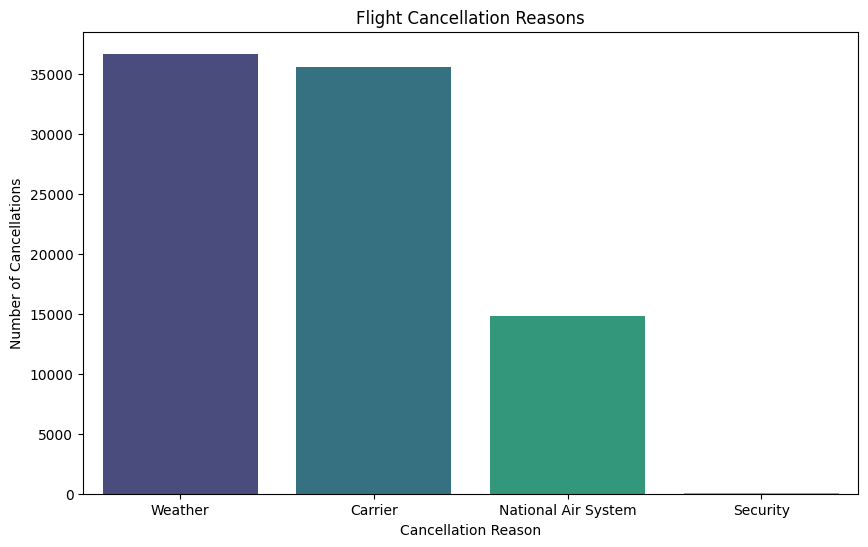

In [25]:
visualize_cancellation_reasons(train_df)

### Top carriers

In [26]:
top_carriers = analyze_top_carriers(train_df)
top_carriers.show()

+-------------+-----------+
|UniqueCarrier|FlightCount|
+-------------+-----------+
|           WN|    1127045|
|           AA|     548194|
|           OO|     544843|
|           MQ|     434577|
|           DL|     424982|
|           US|     411274|
|           UA|     375501|
|           XE|     308340|
|           EV|     297874|
|           NW|     291856|
+-------------+-----------+



In [27]:
train_df.head(10)

[Row(FL_DATE=datetime.date(2009, 9, 29), UniqueCarrier='9E', FlightNum=852, ORIGIN='MSY', DEST='ATL', CRSDepTime=830, DEP_TIME=831.0, DEP_DELAY=1.0, TAXI_OUT=16.0, WHEELS_OFF=847.0, WHEELS_ON=1047.0, TAXI_IN=7.0, CRSArrTime=1055, ARR_TIME=1054.0, ARR_DELAY=-1.0, CANCELLED=0.0, CancellationCode=None, DIVERTED=0.0, CRSElapsedTime=85.0, ActualElapsedTime=83.0, AIR_TIME=60.0, DISTANCE=425.0, CarrierDelay=0.0, WeatherDelay=0.0, NASDelay=0.0, SecurityDelay=0.0, LateAircraftDelay=0.0, Month=9, DayOfWeek=3, label=0),
 Row(FL_DATE=datetime.date(2009, 9, 29), UniqueCarrier='9E', FlightNum=853, ORIGIN='ATL', DEST='IAH', CRSDepTime=1536, DEP_TIME=1533.0, DEP_DELAY=-3.0, TAXI_OUT=15.0, WHEELS_OFF=1548.0, WHEELS_ON=1619.0, TAXI_IN=8.0, CRSArrTime=1647, ARR_TIME=1627.0, ARR_DELAY=-20.0, CANCELLED=0.0, CancellationCode=None, DIVERTED=0.0, CRSElapsedTime=131.0, ActualElapsedTime=114.0, AIR_TIME=91.0, DISTANCE=689.0, CarrierDelay=0.0, WeatherDelay=0.0, NASDelay=0.0, SecurityDelay=0.0, LateAircraftDelay=

### Missing values

In [28]:
analyze_missing_values(train_df)

,column,missing_count,missing_percent,data_type
16,CancellationCode,6326977,98.643003,StringType()
19,ActualElapsedTime,87039,1.357013,DoubleType()
13,ARR_TIME,87039,1.357013,DoubleType()
10,WHEELS_ON,87039,1.357013,DoubleType()
20,AIR_TIME,87038,1.356997,DoubleType()
9,WHEELS_OFF,85787,1.337493,DoubleType()
6,DEP_TIME,82867,1.291968,DoubleType()
21,DISTANCE,0,0.000000,DoubleType()
22,CarrierDelay,0,0.000000,DoubleType()
0,FL_DATE,0,0.000000,DateType()


=== Missing Data Analysis and Imputation ===

1. Analyzing missing values...


Columns with missing values: 7
               column  missing_count  missing_percent     data_type
16   CancellationCode        6326977        98.643003  StringType()
19  ActualElapsedTime          87039         1.357013  DoubleType()
13           ARR_TIME          87039         1.357013  DoubleType()
10          WHEELS_ON          87039         1.357013  DoubleType()
20           AIR_TIME          87038         1.356997  DoubleType()
9          WHEELS_OFF          85787         1.337493  DoubleType()
6            DEP_TIME          82867         1.291968  DoubleType()

3. Analyzing missing patterns by cancellation status...


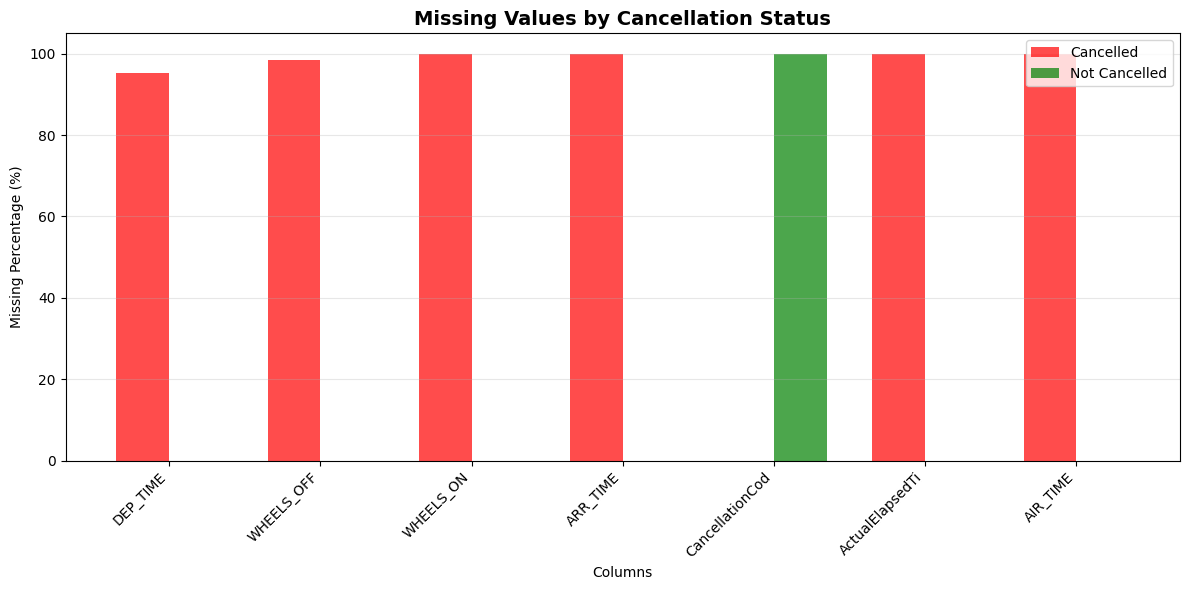


4. Creating imputation strategy...
              Column Strategy
0   CancellationCode     drop
1  ActualElapsedTime     drop
2           ARR_TIME     drop
3          WHEELS_ON     drop
4           AIR_TIME     drop
5         WHEELS_OFF     drop
6           DEP_TIME     drop

5. Applying imputation...

6. Validating imputation...
=== Imputation Validation ===



Missing Value Reduction:
Empty DataFrame
Columns: [column, missing_percent_before, missing_percent_after, reduction]
Index: []


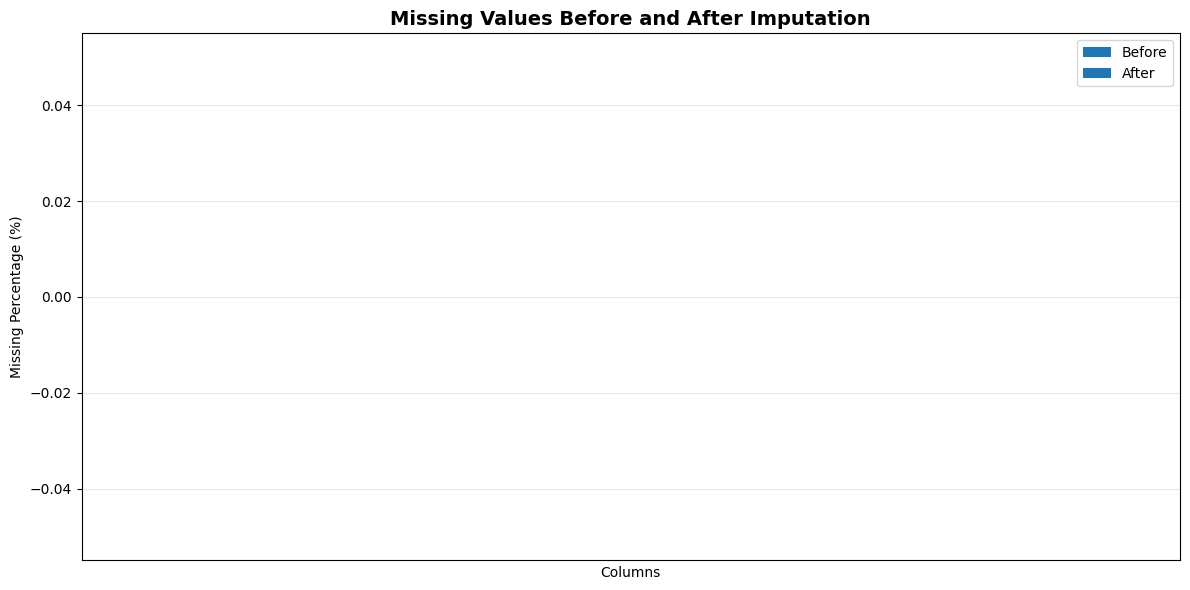

In [29]:
train_df, imputation_results = perform_complete_imputation(train_df)

In [30]:
print(imputation_results)

{'missing_analysis':                column  missing_count  missing_percent      data_type
16   CancellationCode        6326977        98.643003   StringType()
19  ActualElapsedTime          87039         1.357013   DoubleType()
13           ARR_TIME          87039         1.357013   DoubleType()
10          WHEELS_ON          87039         1.357013   DoubleType()
20           AIR_TIME          87038         1.356997   DoubleType()
9          WHEELS_OFF          85787         1.337493   DoubleType()
6            DEP_TIME          82867         1.291968   DoubleType()
21           DISTANCE              0         0.000000   DoubleType()
22       CarrierDelay              0         0.000000   DoubleType()
0             FL_DATE              0         0.000000     DateType()
18     CRSElapsedTime              0         0.000000   DoubleType()
24           NASDelay              0         0.000000   DoubleType()
25      SecurityDelay              0         0.000000   DoubleType()
26  LateAircr

## Feature engineering

In [31]:
train_df.columns # columns we have

['FL_DATE',
 'UniqueCarrier',
 'FlightNum',
 'ORIGIN',
 'DEST',
 'CRSDepTime',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRSArrTime',
 'ARR_DELAY',
 'CANCELLED',
 'DIVERTED',
 'CRSElapsedTime',
 'DISTANCE',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'Month',
 'DayOfWeek',
 'label']

In [38]:
categorical_features = ["ORIGIN", "DEST", "DayOfWeek", "Month"]
numeric_features = ["DISTANCE", "CRSDepTime", "CRSArrTime", "CRSElapsedTime"]

feature_pipeline = create_feature_pipeline(categorical_features, numeric_features)
feature_model = feature_pipeline.fit(train_df)
train_data = feature_model.transform(train_df)

In [33]:
balanced_data = balance_classes_oversampling(train_data, ratio=0.4)


Original ratio: 72.69:1
New ratio: 2.50:1


## Training models

In [34]:
#train_split, test_split = balanced_data.randomSplit([0.7, 0.3], seed=42)
train_split, test_split = balanced_train_test_split(balanced_data, train_size=0.7, seed=42)

Original distribution:
+-----+-------+
|label|  count|
+-----+-------+
|    0|6326977|
|    1|2528606|
+-----+-------+

Train distribution:


+-----+-------+
|label|  count|
+-----+-------+
|    1|1769769|
|    0|4429448|
+-----+-------+

Test distribution:


+-----+-------+
|label|  count|
+-----+-------+
|    1| 758837|
|    0|1897529|
+-----+-------+



In [42]:
# Quick training without cv
models = {
    "LogisticRegression": LogisticRegression(maxIter=100),
    "DecisionTree": DecisionTreeClassifier(maxDepth=10),
    "RandomForest": RandomForestClassifier(numTrees=50, maxDepth=10),
    "GBT": GBTClassifier(maxIter=50, maxDepth=5)
}
fitted_models = {}

results = {}
preds = {}
for name, model in models.items():
    fitted_model = model.fit(train_split)
    fitted_models[name] = fitted_model
    metrics, pred_df = evaluate_model_detailed(fitted_model, test_split) # val
    results[name] = metrics
    preds[name] = pred_df
    
    print(f"{name}: AUC={metrics['AUC']:.4f}, Accuracy={metrics['Accuracy']:.4f}")
    
    # save the fitted model
    fitted_model_path = f"{OUTPUT_PATH}/models_balanced/{name}_fitted"
    fitted_model.write().overwrite().save(fitted_model_path)
    print(f"Saved {name} fitted model to {fitted_model_path}")

LogisticRegression: AUC=0.7517, Accuracy=0.7465
Saved LogisticRegression fitted model to output//models_balanced/LogisticRegression_fitted


DecisionTree: AUC=0.7175, Accuracy=0.7515
Saved DecisionTree fitted model to output//models_balanced/DecisionTree_fitted


25/05/11 15:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1267.3 KiB
25/05/11 15:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1669.8 KiB
25/05/11 15:16:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/11 15:18:47 WARN DAGScheduler: Broadcasting large task binary with size 1045.0 KiB


RandomForest: AUC=0.7324, Accuracy=0.7144
Saved RandomForest fitted model to output//models_balanced/RandomForest_fitted


GBT: AUC=0.7626, Accuracy=0.7603
Saved GBT fitted model to output//models_balanced/GBT_fitted


In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

all_metrics = {}

model_configs = {
    'LogisticRegression': 'LogisticRegression',
    'DecisionTree': 'DecisionTree',
    'RandomForest': 'RandomForest',
    'GBT': 'GBT'
}


# Run scoring and evaluation for each model
for model_name, model_type in model_configs.items():
    print(f"\nScoring with {model_name}...")
    
    # Score the data
    predictions = score_new_data(
        model_name=model_name,
        model_type=model_type,
        model_path=f"{OUTPUT_PATH}/models_balanced/{model_name}_fitted",
        data_path=TEST_PATH,
        output_path=f"{OUTPUT_PATH}/predictions_{model_name.lower()}"
    )
    
    # Calculate metrics
    metrics = {}
    
    # Accuracy
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )
    metrics['accuracy'] = accuracy_evaluator.evaluate(predictions)
    
    # Precision
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision"
    )
    metrics['precision'] = precision_evaluator.evaluate(predictions)
    
    # Recall
    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )
    metrics['recall'] = recall_evaluator.evaluate(predictions)
    
    # F1 Score
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )
    metrics['f1'] = f1_evaluator.evaluate(predictions)
    
    # AUC-ROC
    auc_evaluator = BinaryClassificationEvaluator(
        labelCol="label",
        rawPredictionCol="prediction",
        metricName="areaUnderROC"
    )
    metrics['auc_roc'] = auc_evaluator.evaluate(predictions)
    
    # Store metrics
    all_metrics[model_name] = metrics
    
    # Print metrics for this model
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1: {metrics['f1']:.4f}")
    print(f"AUC-ROC: {metrics['auc_roc']:.4f}")

# Print summary
print("\n" + "="*70)
print("MODEL EVALUATION SUMMARY")
print("="*70)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC-ROC':<10}")
print("-"*70)

for model_name, metrics in all_metrics.items():
    print(f"{model_name:<20} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['auc_roc']:<10.4f}")


Scoring with LogisticRegression...


Predictions saved to output//predictions_logisticregression



LogisticRegression Results:
Accuracy: 0.9051
Precision: 0.9687
Recall: 0.9051
F1: 0.9346
AUC-ROC: 0.5750

Scoring with DecisionTree...


Predictions saved to output//predictions_decisiontree



DecisionTree Results:
Accuracy: 0.9184
Precision: 0.9668
Recall: 0.9184
F1: 0.9414
AUC-ROC: 0.5300

Scoring with RandomForest...


25/05/11 15:39:57 WARN DAGScheduler: Broadcasting large task binary with size 1085.2 KiB


Predictions saved to output//predictions_randomforest



RandomForest Results:
Accuracy: 0.9824
Precision: 0.9659
Recall: 0.9824
F1: 0.9737
AUC-ROC: 0.5000

Scoring with GBT...


Predictions saved to output//predictions_gbt



GBT Results:
Accuracy: 0.9368
Precision: 0.9676
Recall: 0.9368
F1: 0.9515
AUC-ROC: 0.5455

MODEL EVALUATION SUMMARY
Model                Accuracy   Precision  Recall     F1         AUC-ROC   
----------------------------------------------------------------------
LogisticRegression   0.9051     0.9687     0.9051     0.9346     0.5750    
DecisionTree         0.9184     0.9668     0.9184     0.9414     0.5300    
RandomForest         0.9824     0.9659     0.9824     0.9737     0.5000    
GBT                  0.9368     0.9676     0.9368     0.9515     0.5455    


## Using CV

In [48]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

# Define hyperparameter grids (at least one per model)
param_grids = {
    "LogisticRegression": ParamGridBuilder()
        .addGrid(LogisticRegression.regParam, [0.01, 0.1, 1.0])
        .build(),
    
    "DecisionTree": ParamGridBuilder()
        .addGrid(DecisionTreeClassifier.maxDepth, [5, 10, 15])
        .build(),
    
    "RandomForest": ParamGridBuilder()
        .addGrid(RandomForestClassifier.numTrees, [20, 50, 75])
        .build(),
    
    "GBT": ParamGridBuilder()
        .addGrid(GBTClassifier.maxIter, [20, 50])
        .build()
}

results = {}
best_models = {}

for model_name, model in models.items():
    print(f"Training {model_name} with 3-fold CV...")
    
    # Create CrossValidator with 3 folds
    crossval = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grids[model_name],
        evaluator=evaluator,
        numFolds=3
    )
    
    # Fit the model
    cv_model = crossval.fit(train_split)
    best_models[model_name] = cv_model.bestModel
    
    fitted_model_path = f"{OUTPUT_PATH}/models_best/{model_name}_fitted"
    cv_model.bestModel.write().overwrite().save(fitted_model_path)
    print(f"Saved {model_name} fitted model to {fitted_model_path}")
    
    # Evaluate
    metrics = evaluate_model_detailed(cv_model.bestModel, test_split)
    results[model_name] = metrics

Training LogisticRegression with 3-fold CV...


Saved LogisticRegression fitted model to output//models_best/LogisticRegression_fitted


Exception ignored in: <function JavaWrapper.__del__ at 0x14e05ffd2160>          
Traceback (most recent call last):
  File "/gpfs/helios/home/andressebastian1/dev/lib/python3.9/site-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x14e05ffd2160>
Traceback (most recent call last):
  File "/gpfs/helios/home/andressebastian1/dev/lib/python3.9/site-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'MulticlassClassificationEvaluator' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x14e05ffd2160>
Traceback (most recent call last):
  File "/gpfs/helios/home/andressebastian1/dev/lib/python3.9/site-packages/pyspark/ml/wrapper.py", line 53, in __d

Training DecisionTree with 3-fold CV...


Saved DecisionTree fitted model to output//models_best/DecisionTree_fitted


Training RandomForest with 3-fold CV...


25/05/11 16:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
25/05/11 16:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1304.5 KiB
25/05/11 16:11:40 WARN DAGScheduler: Broadcasting large task binary with size 1695.3 KiB
25/05/11 16:12:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/11 16:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB
25/05/11 16:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
25/05/11 16:15:55 WARN DAGScheduler: Broadcasting large task binary with size 1304.5 KiB
25/05/11 16:16:28 WARN DAGScheduler: Broadcasting large task binary with size 1695.3 KiB
25/05/11 16:17:08 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/11 16:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB
25/05/11 16:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
25/05/11 16:20:07 WARN DAGS

Saved RandomForest fitted model to output//models_best/RandomForest_fitted


25/05/11 16:55:41 WARN DAGScheduler: Broadcasting large task binary with size 1019.2 KiB
/gpfs/helios/home/andressebastian1/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/gpfs/helios/home/andressebastian1/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/gpfs/helios/home/andressebastian1/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

Training GBT with 3-fold CV...


25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_161, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_160, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_169, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_141, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_154, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_73, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_60, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_102, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_30, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove block rdd_10289_19, which does not exist
25/05/11 17:03:43 WARN BlockManager: Asked to remove b

Saved GBT fitted model to output//models_best/GBT_fitted


In [56]:
best_models.keys()

dict_keys(['LogisticRegression', 'DecisionTree', 'RandomForest', 'GBT'])

In [60]:
model_name = 'GBT'
best_model = best_models[model_name]

fitted_model_path = f"{OUTPUT_PATH}/models_best/{model_name}_fitted"
best_model.write().overwrite().save(fitted_model_path)

In [54]:
results

{'LogisticRegression': ({'Accuracy': 0.7465142228141755,
   'AUC': 0.7517058862659098,
   'Precision': 0.7242429832621453,
   'Recall': 0.7465142228141755,
   'F1': 0.717294588876693,
   'Cancelled_Precision': 0.6090165732328772,
   'Cancelled_Recall': 0.3146683675150263,
   'Cancelled_F1': 0.41494289326318623},
           label  prediction                                probability  \
  0            0         0.0  [0.8793239666521314, 0.12067603334786858]   
  1            1         1.0  [0.49837785398740064, 0.5016221460125994]   
  2            0         0.0  [0.7584099020141168, 0.24159009798588316]   
  3            0         0.0  [0.9318117165619381, 0.06818828343806194]   
  4            0         0.0       [0.65259364900091, 0.34740635099909]   
  ...        ...         ...                                        ...   
  2656361      0         0.0  [0.8590850000486159, 0.14091499995138412]   
  2656362      0         0.0   [0.8189852495880412, 0.1810147504119588]   
  2656363  

# Inference on 2010 data

In [61]:
for model_name, model in best_models.items():
    print(f"\nScoring with {model_name}...")
    
    # Score the data
    predictions = score_new_data(
        model_name=model_name,
        model_type=model_name,
        model_path=f"{OUTPUT_PATH}/models_best/{model_name}_fitted",
        data_path=TEST_PATH,
        output_path=f"{OUTPUT_PATH}/predictions_{model_name.lower()}"
    )
    
    # Calculate metrics
    metrics = {}
    
    # Accuracy
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )
    metrics['accuracy'] = accuracy_evaluator.evaluate(predictions)
    
    # Precision
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision"
    )
    metrics['precision'] = precision_evaluator.evaluate(predictions)
    
    # Recall
    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )
    metrics['recall'] = recall_evaluator.evaluate(predictions)
    
    # F1 Score
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )
    metrics['f1'] = f1_evaluator.evaluate(predictions)
    
    # AUC-ROC
    auc_evaluator = BinaryClassificationEvaluator(
        labelCol="label",
        rawPredictionCol="prediction",
        metricName="areaUnderROC"
    )
    metrics['auc_roc'] = auc_evaluator.evaluate(predictions)
    
    # Store metrics
    all_metrics[model_name] = metrics
    
    # Print metrics for this model
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1: {metrics['f1']:.4f}")
    print(f"AUC-ROC: {metrics['auc_roc']:.4f}")

# Print summary
print("\n" + "="*70)
print("MODEL EVALUATION SUMMARY")
print("="*70)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC-ROC':<10}")
print("-"*70)

for model_name, metrics in all_metrics.items():
    print(f"{model_name:<20} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['auc_roc']:<10.4f}")


Scoring with LogisticRegression...


Predictions saved to output//predictions_logisticregression



LogisticRegression Results:
Accuracy: 0.9051
Precision: 0.9687
Recall: 0.9051
F1: 0.9346
AUC-ROC: 0.5750

Scoring with DecisionTree...


Predictions saved to output//predictions_decisiontree



DecisionTree Results:
Accuracy: 0.9180
Precision: 0.9668
Recall: 0.9180
F1: 0.9412
AUC-ROC: 0.5306

Scoring with RandomForest...


25/05/11 18:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1059.0 KiB


Predictions saved to output//predictions_randomforest



RandomForest Results:
Accuracy: 0.9824
Precision: 0.9651
Recall: 0.9824
F1: 0.9737
AUC-ROC: 0.5000

Scoring with GBT...


Predictions saved to output//predictions_gbt



GBT Results:
Accuracy: 0.9367
Precision: 0.9677
Recall: 0.9367
F1: 0.9515
AUC-ROC: 0.5474

MODEL EVALUATION SUMMARY
Model                Accuracy   Precision  Recall     F1         AUC-ROC   
----------------------------------------------------------------------
LogisticRegression   0.9051     0.9687     0.9051     0.9346     0.5750    
DecisionTree         0.9180     0.9668     0.9180     0.9412     0.5306    
RandomForest         0.9824     0.9651     0.9824     0.9737     0.5000    
GBT                  0.9367     0.9677     0.9367     0.9515     0.5474    


## Feature Importance

Model does not have feature importances


/tmp/ipykernel_3821077/51510412.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


<Figure size 1200x800 with 0 Axes>

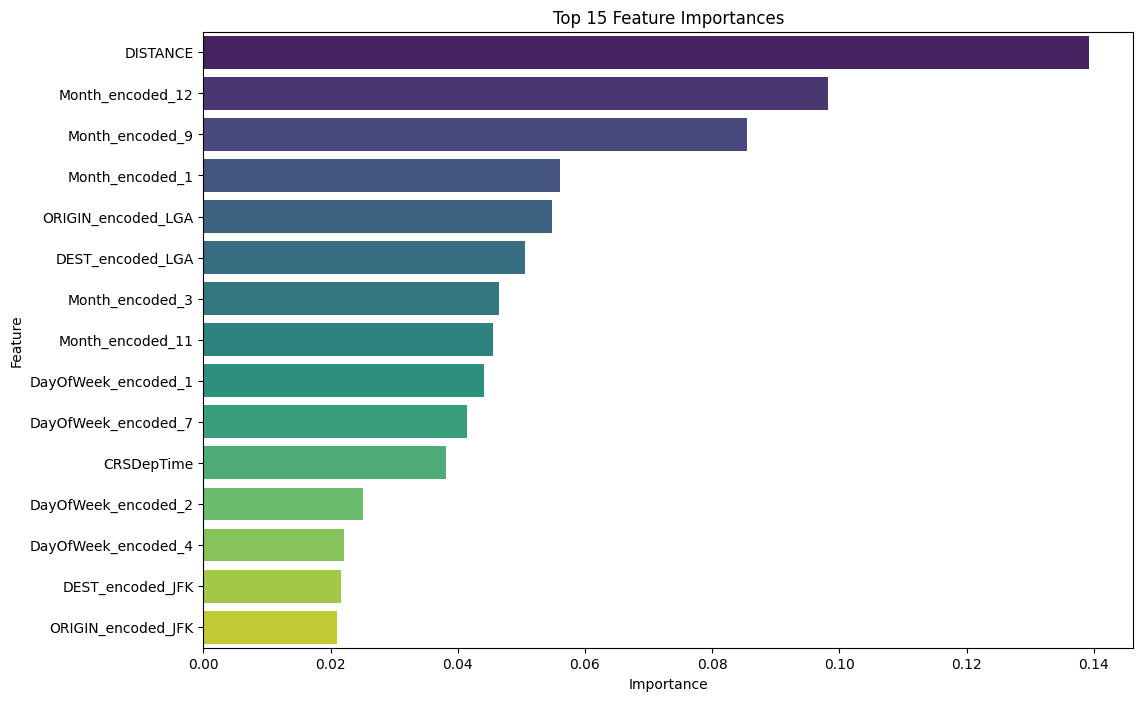

/tmp/ipykernel_3821077/51510412.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


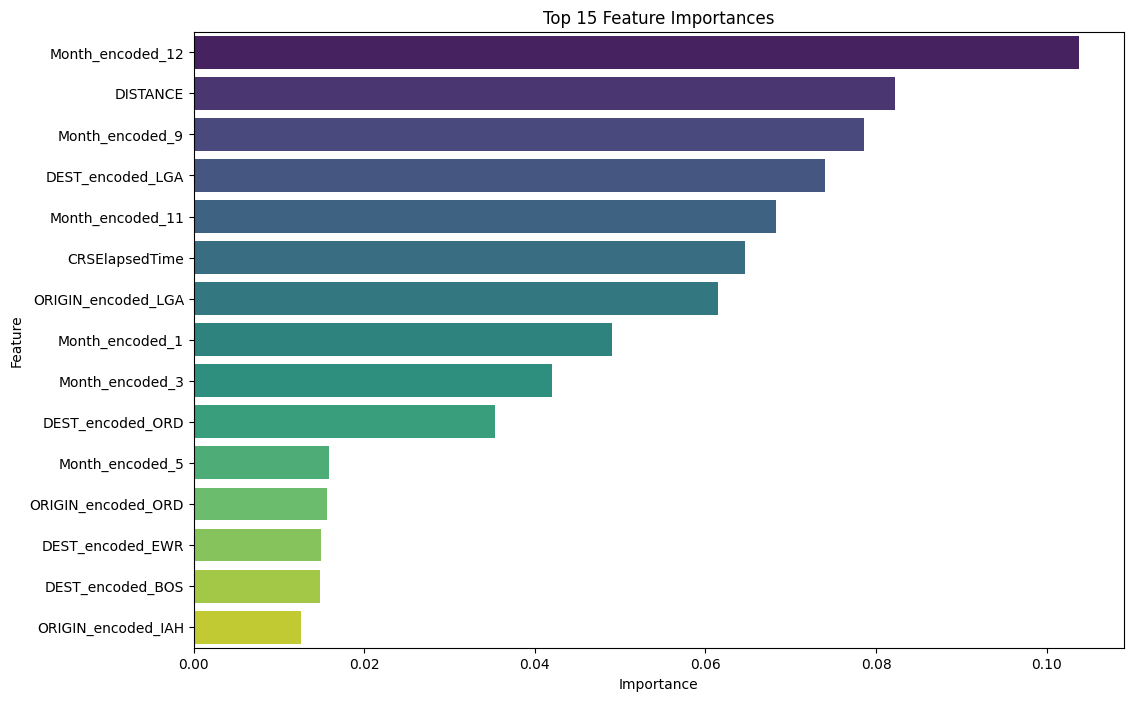

/tmp/ipykernel_3821077/51510412.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


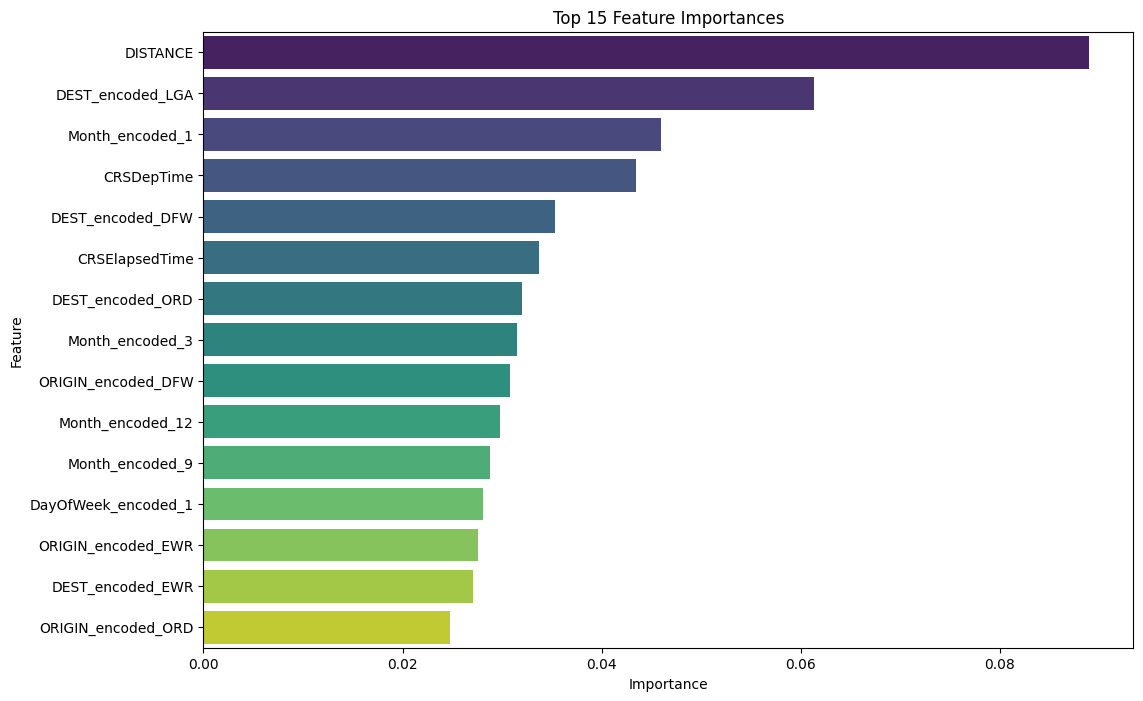

In [70]:
feature_names = []
attrs = train_data.schema["features"].metadata["ml_attr"]["attrs"]
if "binary" in attrs:
    feature_names.extend([attr["name"] for attr in attrs["binary"]])
if "numeric" in attrs:
    feature_names.extend([attr["name"] for attr in attrs["numeric"]])


for model, best_model in best_models.items():    
    try:
        importance_df = extract_feature_importance(best_model, feature_names)
        plot_feature_importance(importance_df, top_n=15)
    except:
        continue

In [50]:
best_models

{'LogisticRegression': LogisticRegressionModel: uid=LogisticRegression_c8cc3c5be1c0, numClasses=2, numFeatures=614,
 'DecisionTree': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ef070f3b0e5a, depth=10, numNodes=1227, numClasses=2, numFeatures=614,
 'RandomForest': RandomForestClassificationModel: uid=RandomForestClassifier_90fdd74328d4, numTrees=50, numClasses=2, numFeatures=614,
 'GBT': GBTClassificationModel: uid = GBTClassifier_4e05219dc321, numTrees=50, numClasses=2, numFeatures=614}


LogisticRegression attributes:
Type: <class 'pyspark.ml.classification.LogisticRegressionModel'>
Has featureImportances: False
Has coefficients: True
Has intercept: True
--------------------------------------------------

DecisionTree attributes:
Type: <class 'pyspark.ml.classification.DecisionTreeClassificationModel'>
Has featureImportances: True
Has coefficients: False
Has intercept: False
--------------------------------------------------

RandomForest attributes:
Type: <class 'pyspark.ml.classification.RandomForestClassificationModel'>
Has featureImportances: True
Has coefficients: False
Has intercept: False
--------------------------------------------------

GBT attributes:
Type: <class 'pyspark.ml.classification.GBTClassificationModel'>
Has featureImportances: True
Has coefficients: False
Has intercept: False
--------------------------------------------------

Analyzing LogisticRegression

LogisticRegression - Logistic Regression Insights:
Intercept: -1.4630285755725252

Top 10 

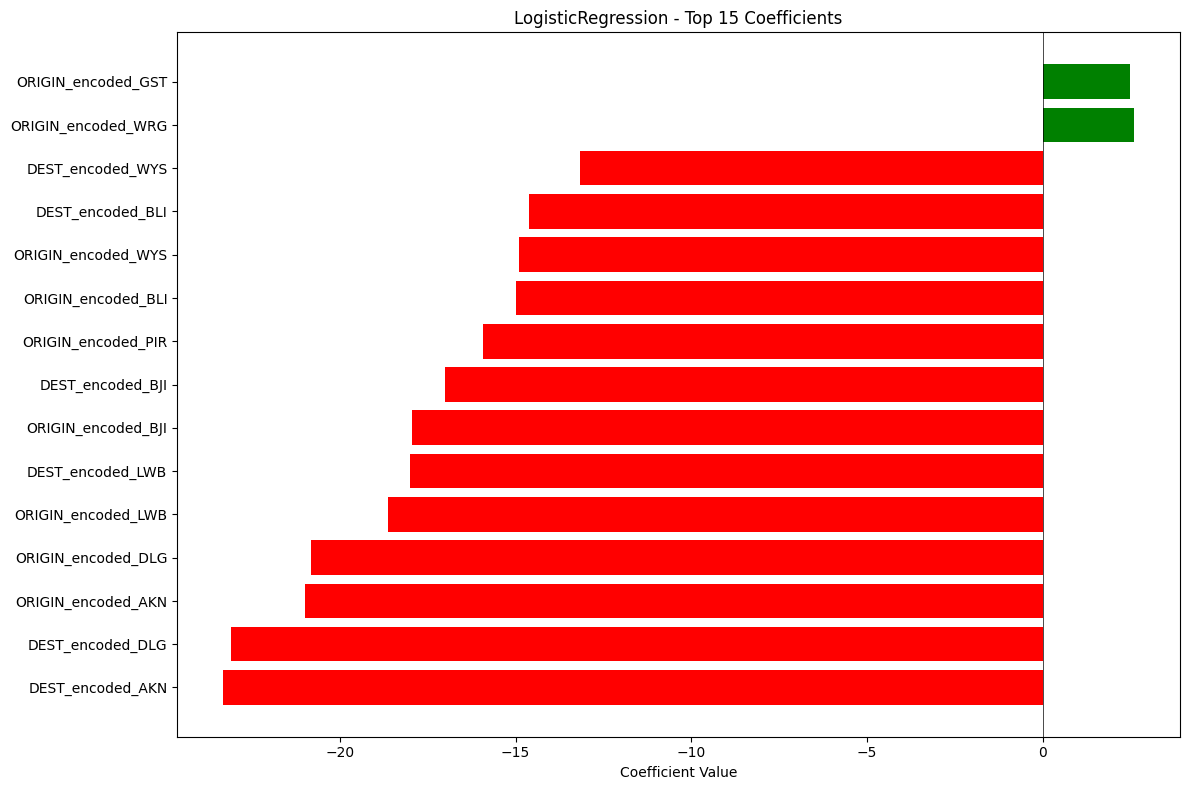


Analyzing DecisionTree

DecisionTree - Feature Importances:

Top 10 Features:
                 feature  importance
610             DISTANCE    0.139269
607     Month_encoded_12    0.098263
599      Month_encoded_9    0.085479
606      Month_encoded_1    0.056085
19    ORIGIN_encoded_LGA    0.054820
315     DEST_encoded_LGA    0.050567
602      Month_encoded_3    0.046453
608     Month_encoded_11    0.045542
597  DayOfWeek_encoded_1    0.044089
598  DayOfWeek_encoded_7    0.041452


/tmp/ipykernel_3821077/2856993776.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


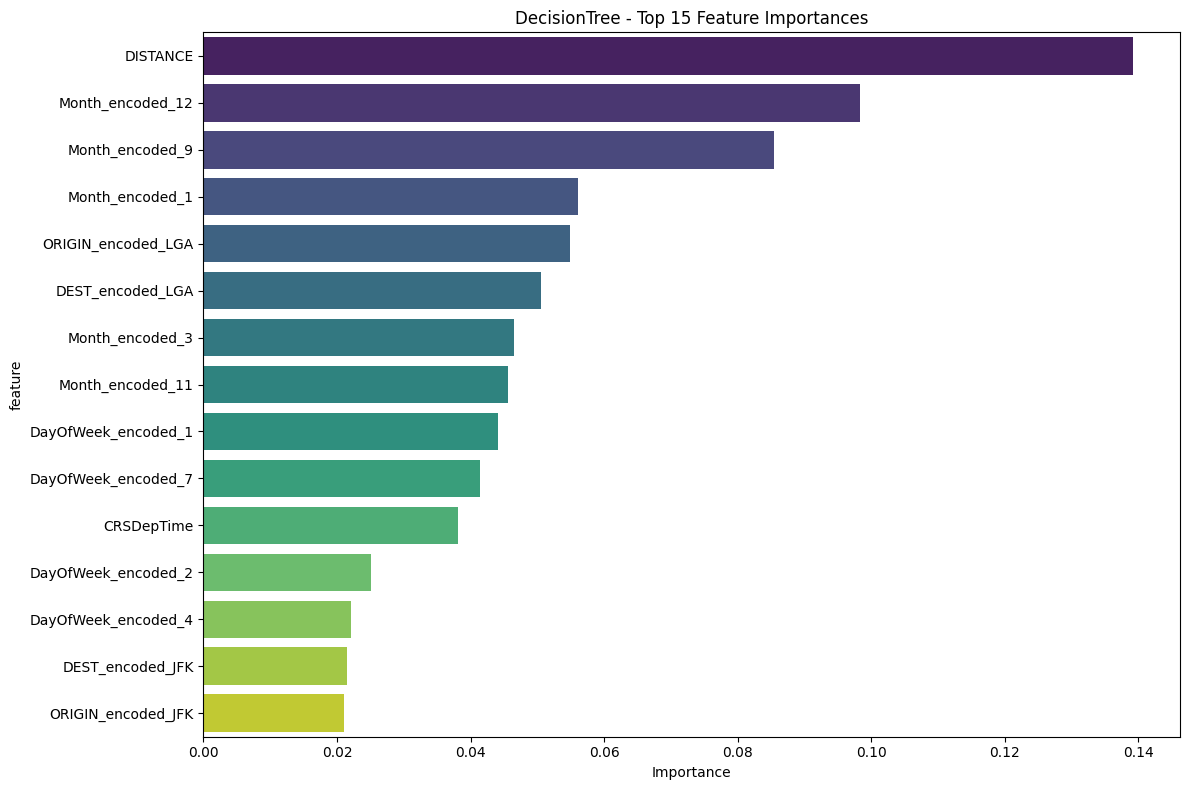


Analyzing RandomForest

RandomForest - Feature Importances:

Top 10 Features:
                feature  importance
607    Month_encoded_12    0.103852
610            DISTANCE    0.082202
599     Month_encoded_9    0.078626
315    DEST_encoded_LGA    0.073956
608    Month_encoded_11    0.068301
613      CRSElapsedTime    0.064594
19   ORIGIN_encoded_LGA    0.061490
606     Month_encoded_1    0.049018
602     Month_encoded_3    0.041948
297    DEST_encoded_ORD    0.035299


/tmp/ipykernel_3821077/2856993776.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


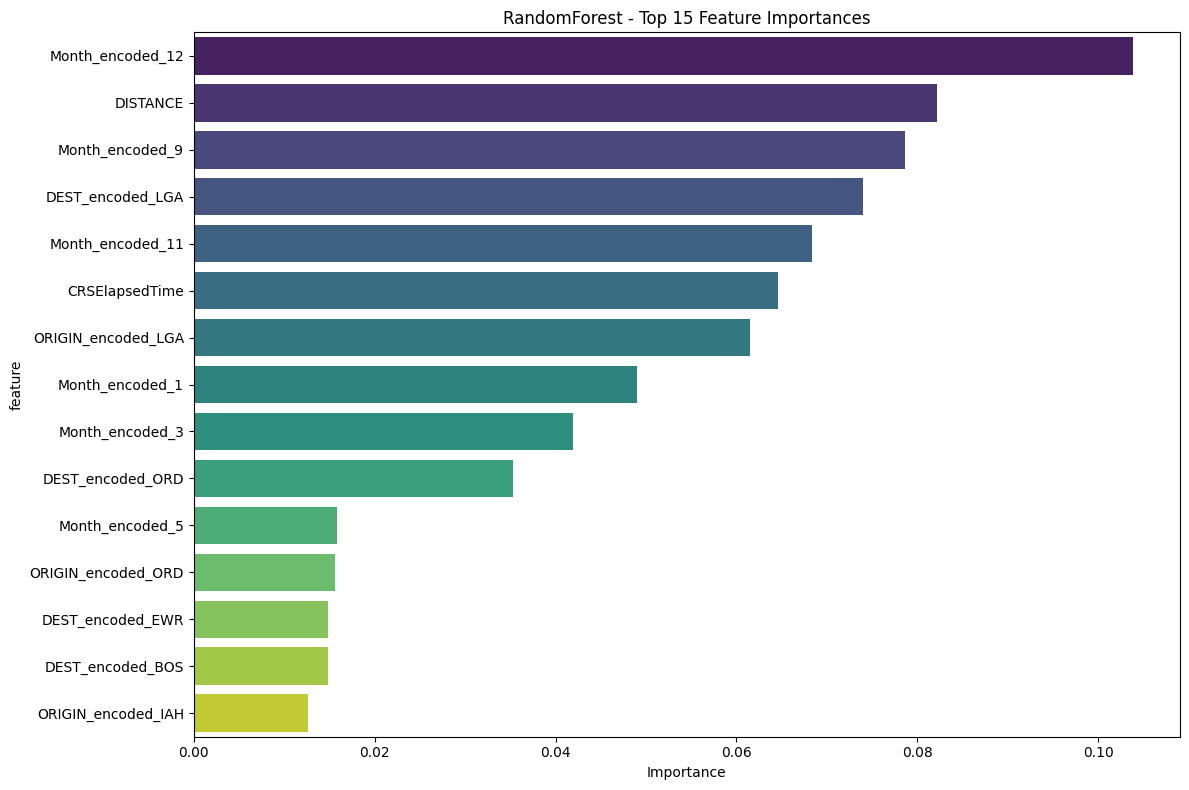


Analyzing GBT

GBT - Feature Importances:

Top 10 Features:
                feature  importance
610            DISTANCE    0.088962
315    DEST_encoded_LGA    0.061343
606     Month_encoded_1    0.045959
611          CRSDepTime    0.043410
298    DEST_encoded_DFW    0.035316
613      CRSElapsedTime    0.033754
297    DEST_encoded_ORD    0.032034
602     Month_encoded_3    0.031524
2    ORIGIN_encoded_DFW    0.030759
607    Month_encoded_12    0.029743


/tmp/ipykernel_3821077/2856993776.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


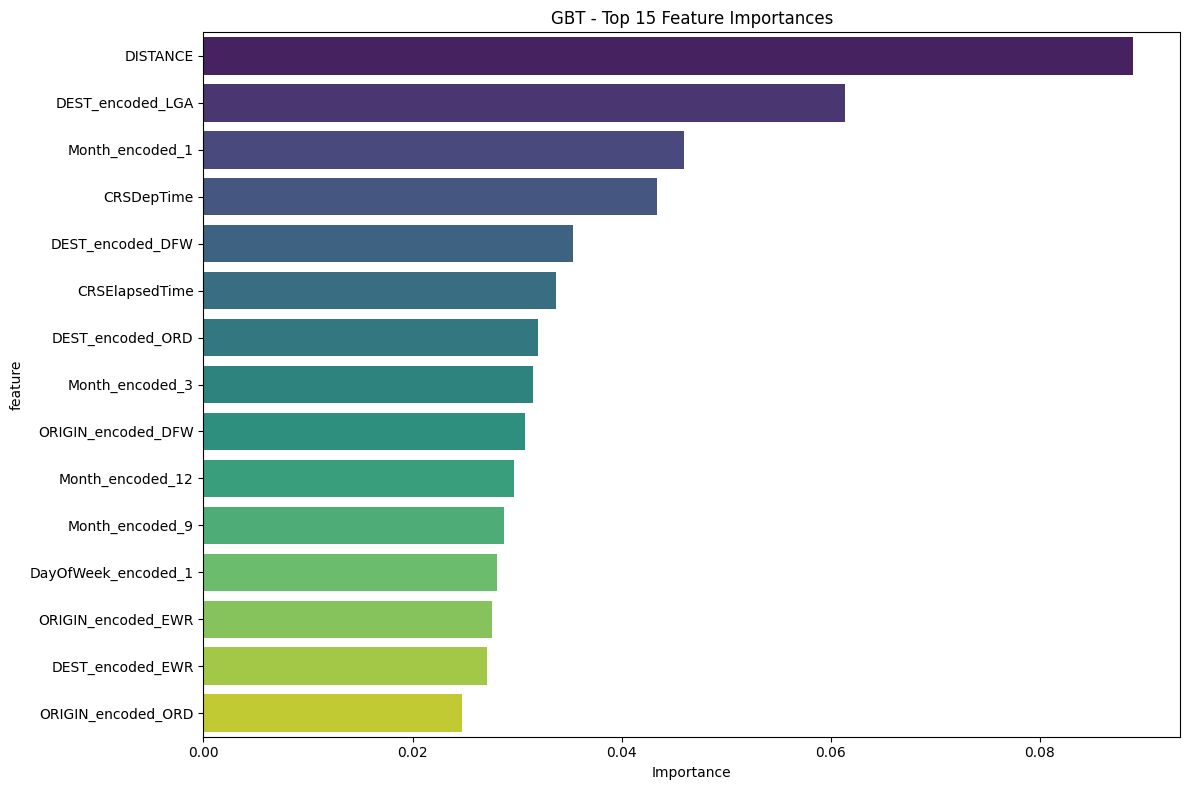

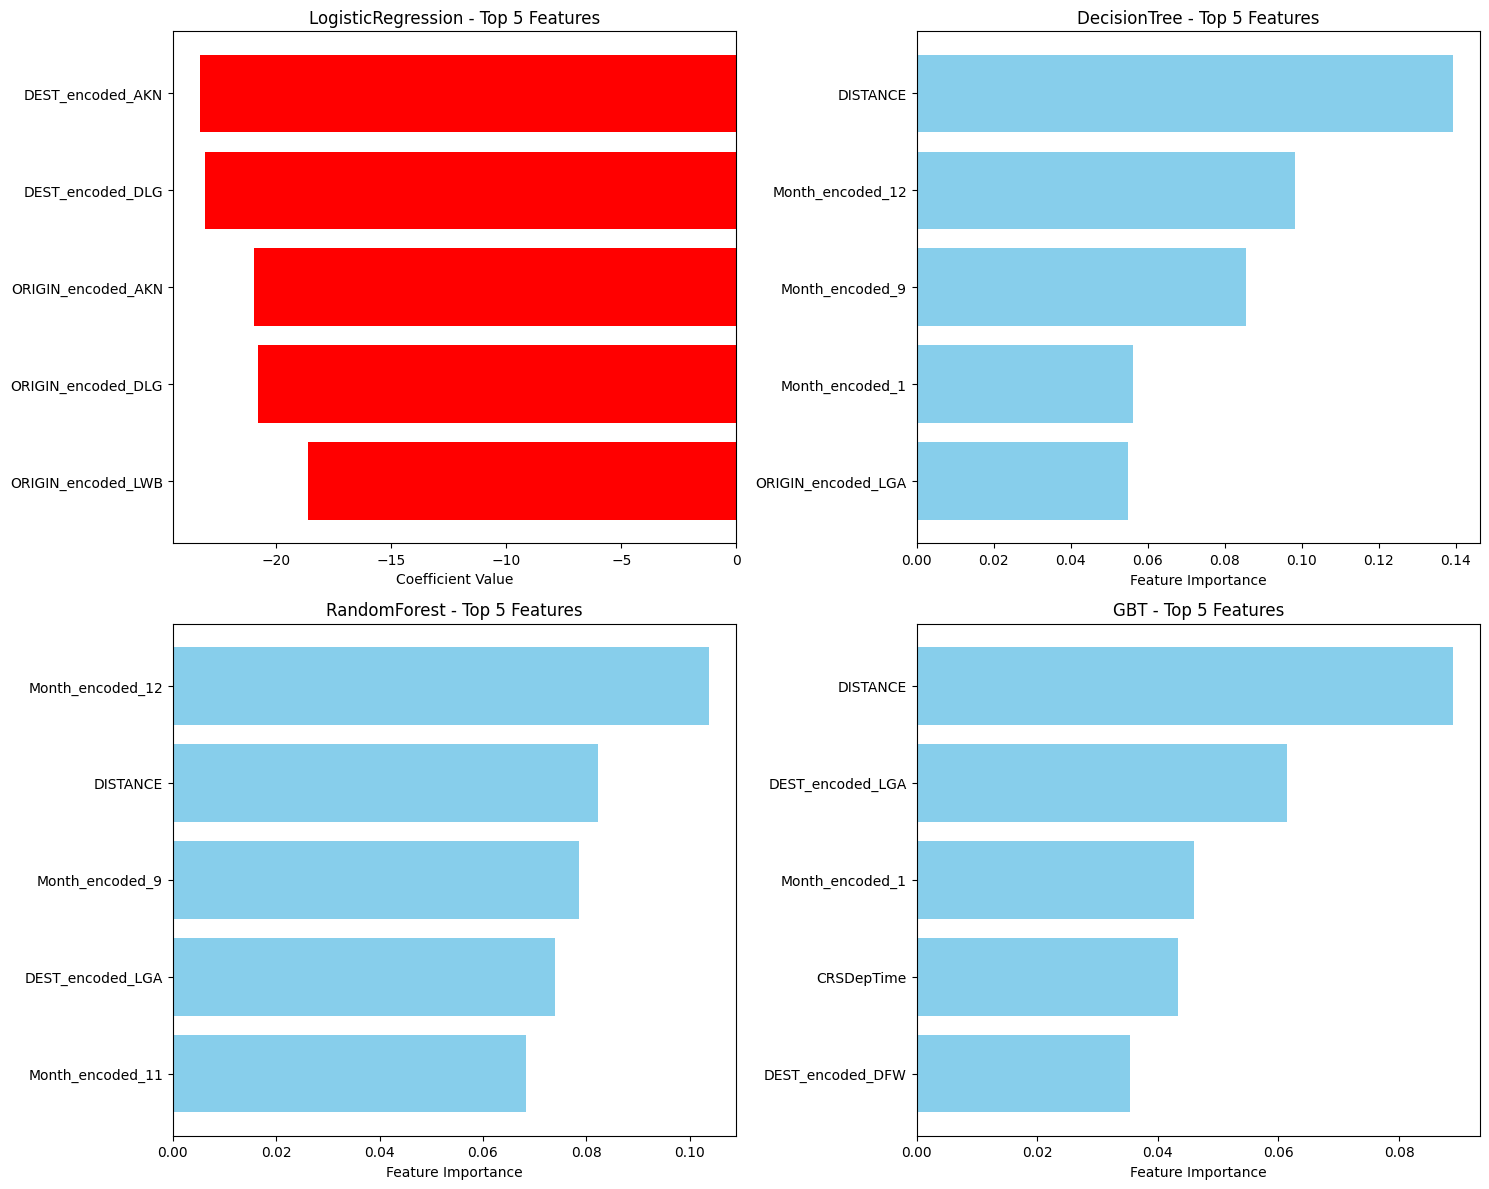

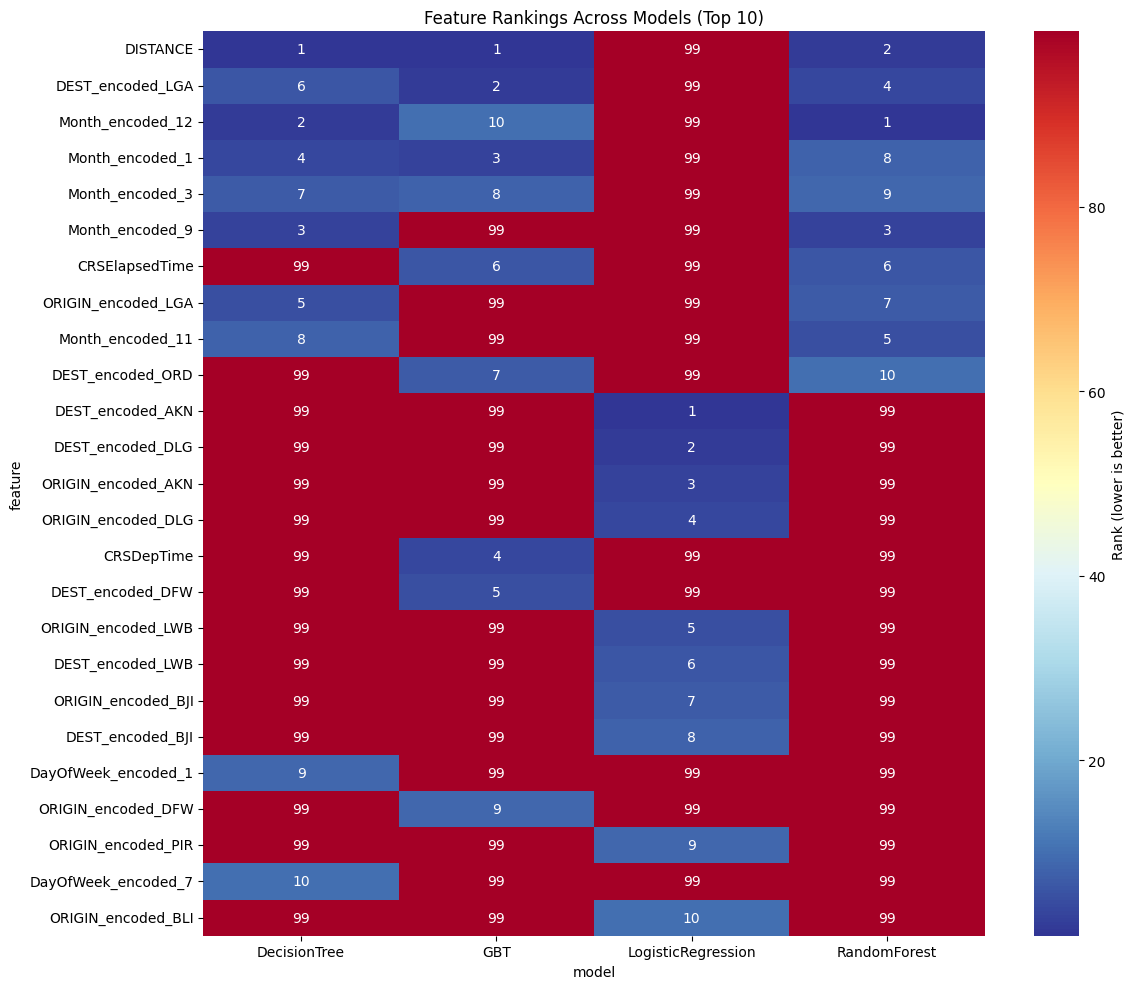


Features appearing in multiple models' top 10:
feature
Month_encoded_1       3
DEST_encoded_LGA      3
DISTANCE              3
Month_encoded_12      3
Month_encoded_3       3
Month_encoded_9       2
ORIGIN_encoded_LGA    2
DEST_encoded_ORD      2
CRSElapsedTime        2
Month_encoded_11      2
dtype: int64

Top Features Summary:
Model        DecisionTree               GBT  LogisticRegression  \
Rank                                                              
1                DISTANCE          DISTANCE    DEST_encoded_AKN   
2        Month_encoded_12  DEST_encoded_LGA    DEST_encoded_DLG   
3         Month_encoded_9   Month_encoded_1  ORIGIN_encoded_AKN   
4         Month_encoded_1        CRSDepTime  ORIGIN_encoded_DLG   
5      ORIGIN_encoded_LGA  DEST_encoded_DFW  ORIGIN_encoded_LWB   

Model      RandomForest  
Rank                     
1      Month_encoded_12  
2              DISTANCE  
3       Month_encoded_9  
4      DEST_encoded_LGA  
5      Month_encoded_11  

Feature Values:

In [73]:
from pyspark.ml.classification import LogisticRegressionModel, DecisionTreeClassificationModel, RandomForestClassificationModel, GBTClassificationModel

for model_name, model in best_models.items():
    print(f"\n{model_name} attributes:")
    print(f"Type: {type(model)}")
    
    # For CrossValidatorModel, get the bestModel
    if hasattr(model, 'bestModel'):
        actual_model = model.bestModel
        print(f"Best Model Type: {type(actual_model)}")
    else:
        actual_model = model
    
    # Check for different attributes
    print(f"Has featureImportances: {hasattr(actual_model, 'featureImportances')}")
    print(f"Has coefficients: {hasattr(actual_model, 'coefficients')}")
    print(f"Has intercept: {hasattr(actual_model, 'intercept')}")
    print("-" * 50)

# Function to extract model insights based on model type
def extract_model_insights(model, feature_names, model_name):
    """Extract insights from different model types"""
    
    # Handle CrossValidatorModel
    if hasattr(model, 'bestModel'):
        model = model.bestModel
    
    if isinstance(model, LogisticRegressionModel):
        # For Logistic Regression, extract coefficients
        coefficients = model.coefficients.toArray()
        intercept = model.intercept
        
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        }).sort_values('abs_coefficient', ascending=False)
        
        print(f"\n{model_name} - Logistic Regression Insights:")
        print(f"Intercept: {intercept}")
        print("\nTop 10 Features by Absolute Coefficient:")
        print(coef_df.head(10))
        
        # Visualize coefficients
        plt.figure(figsize=(12, 8))
        top_coefs = coef_df.head(15)
        colors = ['red' if x < 0 else 'green' for x in top_coefs['coefficient']]
        
        plt.barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors)
        plt.yticks(range(len(top_coefs)), top_coefs['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'{model_name} - Top 15 Coefficients')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        
        return coef_df
        
    elif isinstance(model, (DecisionTreeClassificationModel, RandomForestClassificationModel, GBTClassificationModel)):
        # For tree-based models, extract feature importances
        importances = model.featureImportances.toArray()
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n{model_name} - Feature Importances:")
        print("\nTop 10 Features:")
        print(importance_df.head(10))
        
        # Visualize feature importances
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        
        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'{model_name} - Top 15 Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    
    else:
        print(f"Unknown model type: {type(model)}")
        return None

# Extract insights for all models
model_insights = {}

for model_name, model in best_models.items():
    print(f"\n{'='*60}")
    print(f"Analyzing {model_name}")
    print(f"{'='*60}")
    
    insights = extract_model_insights(model, feature_names, model_name)
    if insights is not None:
        model_insights[model_name] = insights

# Create a summary comparison of top features across models
# Fixed comparison function
def compare_top_features(model_insights, top_n=10):
    """Compare top features across different models"""
    
    comparison_data = []
    
    for model_name, insights in model_insights.items():
        if 'coefficient' in insights.columns:
            # For logistic regression, use absolute coefficient
            top_features = insights.nlargest(top_n, 'abs_coefficient')
            for rank, (_, row) in enumerate(top_features.iterrows(), 1):
                comparison_data.append({
                    'model': model_name,
                    'rank': rank,
                    'feature': row['feature'],
                    'value': row['abs_coefficient'],
                    'type': 'coefficient'
                })
        else:
            # For tree-based models, use importance
            top_features = insights.nlargest(top_n, 'importance')
            for rank, (_, row) in enumerate(top_features.iterrows(), 1):
                comparison_data.append({
                    'model': model_name,
                    'rank': rank,
                    'feature': row['feature'],
                    'value': row['importance'],
                    'type': 'importance'
                })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create a heatmap showing feature rankings across models
    pivot_df = comparison_df.pivot_table(
        index='feature', 
        columns='model', 
        values='rank', 
        fill_value=99  # Large value for features not in top N
    )
    
    # Sort by average rank
    pivot_df['avg_rank'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df.sort_values('avg_rank').drop('avg_rank', axis=1)
    
    # Only show features that appear in at least one model's top N
    mask = (pivot_df < 99).any(axis=1)
    pivot_df = pivot_df[mask]
    
    # Convert to integers to avoid formatting issues
    pivot_df = pivot_df.astype(int)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_df, annot=True, fmt='d', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Rank (lower is better)'})
    plt.title(f'Feature Rankings Across Models (Top {top_n})')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Alternative simpler visualization - bar chart comparing top features
def plot_feature_comparison(model_insights, top_n=5):
    """Create bar chart comparing top features across models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (model_name, insights) in enumerate(model_insights.items()):
        ax = axes[idx]
        
        if 'coefficient' in insights.columns:
            # For logistic regression
            top_features = insights.nlargest(top_n, 'abs_coefficient')
            colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
            ax.barh(range(top_n), top_features['coefficient'], color=colors)
            ax.set_yticks(range(top_n))
            ax.set_yticklabels(top_features['feature'])
            ax.set_xlabel('Coefficient Value')
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        else:
            # For tree-based models
            top_features = insights.nlargest(top_n, 'importance')
            ax.barh(range(top_n), top_features['importance'], color='skyblue')
            ax.set_yticks(range(top_n))
            ax.set_yticklabels(top_features['feature'])
            ax.set_xlabel('Feature Importance')
        
        ax.set_title(f'{model_name} - Top {top_n} Features')
        ax.invert_yaxis()  # To have the most important feature at the top
    
    plt.tight_layout()
    plt.show()

# Create both visualizations
if model_insights:
    # Bar chart comparison
    plot_feature_comparison(model_insights, top_n=5)
    
    # Heatmap comparison (if you have more than one model)
    if len(model_insights) > 1:
        comparison = compare_top_features(model_insights, top_n=10)
        
        # Show which features are consistently important
        feature_frequency = comparison.groupby('feature').size().sort_values(ascending=False)
        print("\nFeatures appearing in multiple models' top 10:")
        print(feature_frequency[feature_frequency > 1])
    else:
        print("Only one model available, skipping comparison heatmap")

# Create a summary table of top features
def create_feature_summary(model_insights, top_n=5):
    """Create a summary table of top features for each model"""
    
    summary_data = []
    
    for model_name, insights in model_insights.items():
        if 'coefficient' in insights.columns:
            top_features = insights.nlargest(top_n, 'abs_coefficient')
            for rank, (_, row) in enumerate(top_features.iterrows(), 1):
                summary_data.append({
                    'Model': model_name,
                    'Rank': rank,
                    'Feature': row['feature'],
                    'Value': f"{row['coefficient']:.4f}",
                    'Type': 'Coefficient'
                })
        else:
            top_features = insights.nlargest(top_n, 'importance')
            for rank, (_, row) in enumerate(top_features.iterrows(), 1):
                summary_data.append({
                    'Model': model_name,
                    'Rank': rank,
                    'Feature': row['feature'],
                    'Value': f"{row['importance']:.4f}",
                    'Type': 'Importance'
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create a pivot table for easier comparison
    pivot_summary = summary_df.pivot_table(
        index=['Rank'],
        columns=['Model'],
        values=['Feature', 'Value'],
        aggfunc='first'
    )
    
    print("\nTop Features Summary:")
    print(summary_df.pivot(index='Rank', columns='Model', values='Feature'))
    
    print("\nFeature Values:")
    print(summary_df.pivot(index='Rank', columns='Model', values='Value'))
    
    return summary_df

# Create the summary
summary = create_feature_summary(model_insights, top_n=5)

# Show which features are consistently important
feature_frequency = comparison.groupby('feature').size().sort_values(ascending=False)
print("\nFeatures appearing in multiple models' top 10:")
print(feature_frequency[feature_frequency > 1])